# Grids in PorePy and PyGeoN

In this tutorial we investigate the PorePy and PyGeoN grids, and explain how to access information stored in the grid. 

## Basic grid construction

The simplest grids are Cartesian. PorePy can create Cartesian grids in 1d, 2d, and 3d. 
There are 0d point grids as well, which are mainly used in the context of intersecting fractures. 
A 2d Cartesian grid can be created as follows:

In [1]:
import numpy as np
import porepy as pp

num_cells = np.array([3, 2])
sd = pp.CartGrid(num_cells)

The resulting cells will be of unit size, thus the grid covers the domain $[0, 3]\times [0,2]$. 
To specify the domain size, we need to pass a second argument

In [2]:
phys_dims = np.array([1, 1])
sd_1 = pp.CartGrid(num_cells, phys_dims)

Once instantiated, the grids have both node coordinates and topological information that we can access and work with. 
The former will be presented below, and the latter is shown in a separate tutorial. 

To check the grid size, several attributes are provided:

In [3]:
# Number of cells,
print(sd.num_cells)

# number of faces,
print(sd.num_faces)

# and number of nodes
print(sd.num_nodes)

# The grid's dimension is obtained as follows
print(sd.dim)

6
17
12
2


We can also print a summary of the grid's properties:

In [4]:
print(sd)

Cartesian grid in 2 dimensions.
Number of cells 6
Number of faces 17
Number of nodes 12



The node coordinates are stored as 

In [5]:
sd.nodes

array([[0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.],
       [0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

and

In [6]:
sd_1.nodes

array([[0.        , 0.33333333, 0.66666667, 1.        , 0.        ,
        0.33333333, 0.66666667, 1.        , 0.        , 0.33333333,
        0.66666667, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.5       , 0.5       , 0.5       , 1.        , 1.        ,
        1.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

As expected, the second grid covers a larger area.

We also see that even though the grids are 2d, the nodes have three coordinates. 
This is general, all geometric quantities in `PorePy` have three dimensions, even if they represent objects that are genuinely lower-dimensional. 
The reason is that for fractured media, we will often work with grids on fracture surfaces that are embedded in 3d domains, and treating this as special cases throughout the code turned out to be overly cumbersome. 
Also note that the third dimension was introduced automatically, so users need not worry about this. 

In [7]:
sd.cell_centers

AttributeError: 'CartGrid' object has no attribute 'cell_centers'

# Geometric quantities

To compute additional geometric quantities, grids come with the method `compute_geometry()` that will add attributes `cell_centers`, `face_centers` and `face_normals`:

In [8]:
sd.compute_geometry()
print(sd.cell_centers)
print(sd.cell_volumes)
print(sd.face_areas)

[[0.5 1.5 2.5 0.5 1.5 2.5]
 [0.5 0.5 0.5 1.5 1.5 1.5]
 [0.  0.  0.  0.  0.  0. ]]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


And similar for face information. 
It is of course possible to set the geometric quantities manually. 
Be aware that a subsequent call to `compute_geometry()` will overwrite this information.

It may, for some users, be useful to consider grids with a Cartesian topology, but with perturbed geometry. 
This is achieved by perturbing the nodes, and then (re)-computing geometry:

In [9]:
sd_1.compute_geometry()
print(sd_1.cell_centers)

sd_1.nodes[:2] = sd_1.nodes[:2] + np.random.random((sd_1.nodes[:2].shape))
sd_1.compute_geometry()
print(sd_1.cell_centers)

[[0.16666667 0.5        0.83333333 0.16666667 0.5        0.83333333]
 [0.25       0.25       0.25       0.75       0.75       0.75      ]
 [0.         0.         0.         0.         0.         0.        ]]


AssertionError: 

When perturbing nodes, make sure to limit the distortion so that the grid topology still is valid; if not, all kinds of problems may arise.

## Visualization

`PorePy` provides two ways of visualizing the grid, matplotlib, and vtk/ParaView. Matplotlib visualization is done by

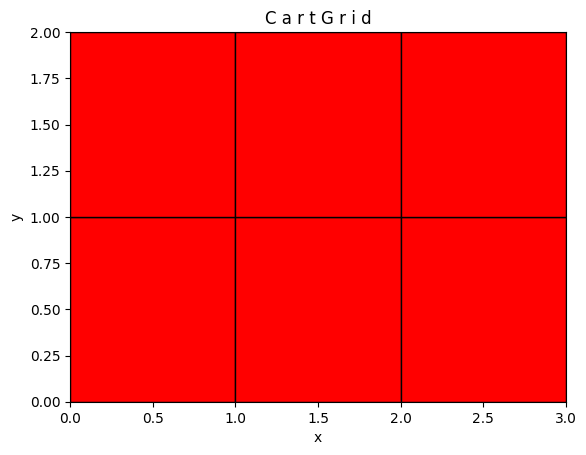

In [10]:
pp.plot_grid(sd, plot_2d=True)

The matplotlib interface is most useful for quick visualization, e.g. during debugging, and other visualization tools are recommended to be used otherwise. 

For showing information about cell numbers, node numbers, face numbers and face normals, we can assign values to the parameters `info` and `alpha` in `pp.plot_grid()`.
The parameter `info` decides which extra information is shown and the value of `alpha` determines the transparency of the grid.


For instance, the lines of code below will plot a grid where we can see cell-, face- and node numbers, in addition to having all the cells colored with separate colors:

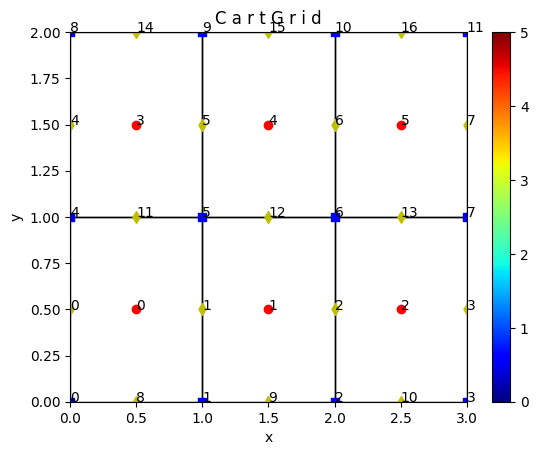

In [11]:
cell_id = np.arange(sd.num_cells)
pp.plot_grid(
    sd, cell_value=cell_id, info="ncf", alpha=0, figsize=(15, 12), plot_2d=True
)

For further information, see the documentation of `plot_grid`.

The second visualization option dumps the grid to a vtu file:

In [12]:
e = pp.Exporter(sd, "grid")
e.write_vtu()

This file can then be accessed by e.g. [ParaView](https://www.paraview.org/). 
There is an entire tutorial related to exporting of data, so for a thorough walk-through of this we refer to the [exporter tutorial](./exporter.ipynb).

# Simplex grids


In addition to constructor methods for Cartesian grids in 2d and 3d, PorePy supoorts simplex grids in both 2d and 3d. 
The simplex grids can be specified either by point coordinates and a cell-node map (e.g. a Delaunay triangulation), or simply by the node coordinates. 
In the latter case, the Delaunay triangulation (or the 3d equivalent) will be used to construct the grid. 
The representation of grid geometry and topology is the same for Cartesian and simplex grids. 
This allows for setting up simulations, defining discretization methods etc., in ways that are agnostic to the problem dimension.

As an example, we make a triangle grid using the nodes of g, distorting the y coordinate of the two central nodes slightly: 


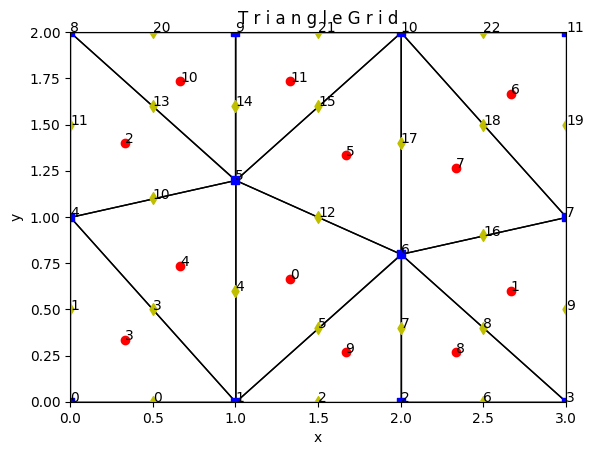

In [13]:
nodes = sd.nodes[:2]
nodes[1, 5:7] = np.array([1.2, 0.8])

sd = pp.TriangleGrid(nodes)
sd.compute_geometry()
pp.plot_grid(sd, alpha=0, info="cfn", plot_2d=True)

A structured triangular grid (squares divided into two) is also provided:

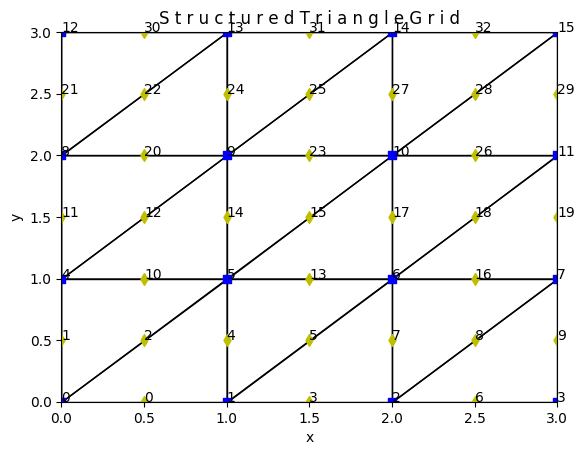

In [18]:
g = pp.StructuredTriangleGrid([3] * 2)
g.compute_geometry()


pp.plot_grid(g, plot_2d=True, info="fn", alpha=0)

In [19]:
g.face_nodes[:, 4].nonzero()[0]

array([1, 5], dtype=int32)

# Import of grids from external meshing tools

Currently, PorePy supports import of grids from Gmsh. 

The grid structure in PorePy is fairly general, and can support a much wider class of grids than those currently implemented. 
To import a new type of grid, all that is needed is to construct the face-node and cell-face maps, together with importing the node coordinates. 
Remaining geometric attributes can then be calculated by the `compute_geometry()` function. 


# Grid topology

In this tutorial we will have a more advanced take on the grid structure, specifically the topological information of the grids. 
We recommend reading the [grid](./grids.ipynb) tutorial before starting on this tutorial.

Before tackling the topological information, we will re-use the basic grid we created in the previous grid structure tutorial:


In [20]:
import numpy as np
import porepy as pp

num_cells = np.array([3, 2])
sd = pp.CartGrid(num_cells)
sd.compute_geometry()

And for visualization purposes we also include the same plot as before:

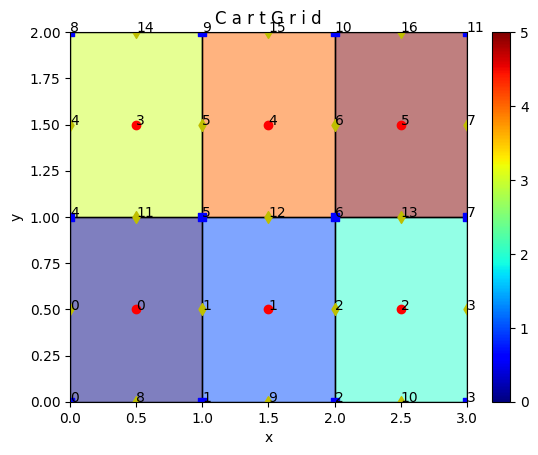

In [21]:
cell_id = np.arange(sd.num_cells)
pp.plot_grid(
    sd, cell_value=cell_id, info="cfn", alpha=0.5, figsize=(15, 12), plot_2d=True
)

For the rest of this tutorial, we will advice the user to sporadically have a look at this plot. 
All the face numbers, node numbers, etc. gathered further down are shown nicely in this figure. 
It can therefore be helpful as a visual guide. 

# Topological information

In addition to storing coordinates of cells, faces and nodes, the grid object also keeps track of the relation between them. 
Specifically, we can access:
1. The relation between cells and faces
2. The relation between faces and nodes
3. The direction of `face_normals`, as in which of the neighboring cells has the normal vector as outwards pointing.

Note that there is no notion of edges for 3d grids. 
These are not usually needed for the type of numerical methods that are primarily of interest in `porepy`. 
The information can still be recovered from the face-node relations, see comments below.

The topological information is stored in two attributes, `cell_faces` and `face_nodes`. 
The latter has the simplest interpretation, so we start out with that one:

In [22]:
sd.face_nodes
print(sd.face_nodes.todense().astype(int))
print(sd.num_faces, sd.num_nodes)

[[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]]
17 12


We see that the information is stored as a scipy.sparse matrix. 
From the shape of the matrix, we conclude that the rows represent nodes, while the faces are stored in columns. 
We can get the nodes for the first face by brute force by writing

In [23]:
sd.face_nodes[:, 5].nonzero()[0]

array([5, 9], dtype=int32)

Similarly, we can also get the faces of a node, for example the sixth (counting from 0) node:

In [24]:
sd.face_nodes[5, :].nonzero()[1]

array([ 1,  5, 11, 12], dtype=int32)

The map between cells and faces is stored in the same way, thus the faces of cell 0 are found by

In [25]:
faces_of_cell_0 = sd.cell_faces[:, 0].nonzero()[0]
print(faces_of_cell_0)

[ 0  1  8 11]


`cell_faces` also keeps track of the direction of the normal vector relative to the neighboring cells.
This is done by storing data as $\pm 1$, or zero if there is no connection between the cells (in contrast, `face_nodes` simply consist of `True` or `False`).

In [26]:
print(sd.cell_faces[:, 0].data)
print(sd.face_normals)

[-1  1 -1  1]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]


Compare this with the face normal vectors, which can either be gathered in an array or shown using `pp.plot_grid`:

In [27]:
sd.face_normals[: g.dim, faces_of_cell_0]

array([[1., 1., 0., 0.],
       [0., 0., 1., 1.]])

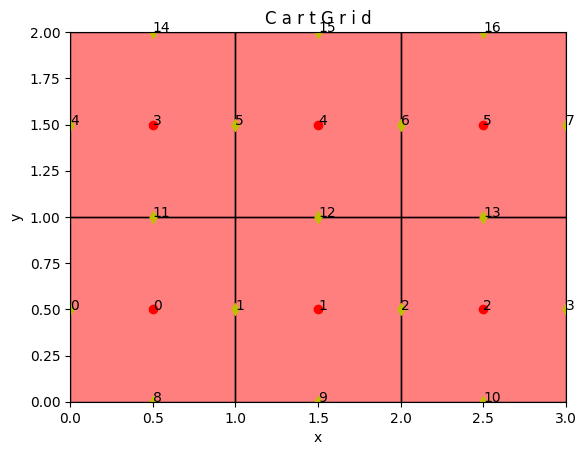

In [28]:
pp.plot_grid(sd, info="cf", alpha=0.5, figsize=(15, 12), plot_2d=True)

As can be seen from both the normal vector array and the figure, we observe that positive data corresponds to the normal vector pointing out of the cell. 
This is a very useful feature, since it in effect means that the transpose of `g.cell_faces` is the discrete divergence operator for the grid.


Finally, we note that to get a cell-node relation, we can combine `cell_faces` and `face_nodes`. 
However, since `cell_faces` contains both positive and negative values, we need to take the absolute value of the data. This procedure is implemented in the method `cell_nodes()`, which returns a sparse matrix that can be handled in the usual way

In [30]:
import inspect

print(inspect.getsource(sd.cell_nodes))
sd.cell_nodes()[:, 0].nonzero()[0]

    def cell_nodes(self) -> sps.csc_matrix:
        """Obtain mapping between cells and nodes.

        Returns:
            An array with ``shape=(num_nodes, num_cells)`` representing the mapping from
            cells to nodes spanning respective cell.

            The value 1 indicates a connection between a cell and node column-wise.

        """
        mat = (self.face_nodes @ np.abs(self.cell_faces)) > 0
        return mat.tocsc()



array([0, 1, 4, 5], dtype=int32)

# The PyGeoN grids

PyGeoN starts from the grid provided by PorePy and add additional attributes to them. Moreover, PyGeoN gives some additional functionalities to construct simple grids. Let us see these aspects now.

Let us generate a simple triangular grid for the unit square.

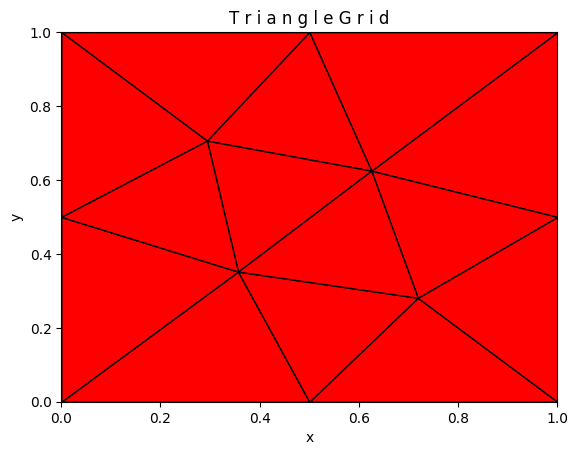

In [31]:
import pygeon as pg

mesh_size = 0.5
sd = pg.unit_grid(2, mesh_size, as_mdg=False)
pp.plot_grid(sd, plot_2d=True)

A 3d grid can be generated similarly by changing the first input argument

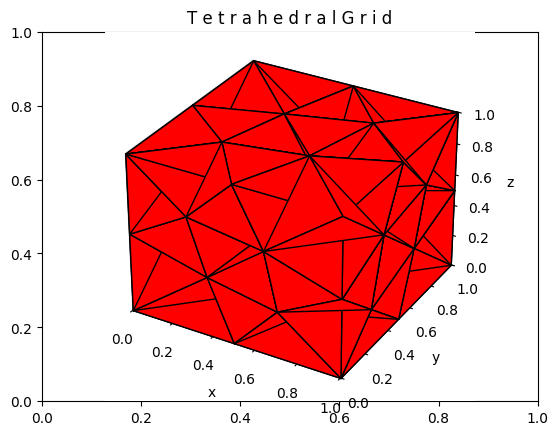

In [32]:
sd_3d = pg.unit_grid(3, mesh_size, as_mdg=False)
pp.plot_grid(sd_3d)

It is possible to convert a grid from PorePy to PyGeoN and then by using the `compute_geometry` function compute additional geometrical information.

In [33]:
sd = pp.CartGrid(num_cells)
pg.convert_from_pp(sd)

print(type(sd))
print(dir(sd))

sd.compute_geometry()

<class 'pygeon.grids.grid.Grid'>
['_Grid__id', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_check_tags', '_compute_geometry_0d', '_compute_geometry_1d', '_compute_geometry_2d', '_compute_geometry_3d', '_compute_ridges_01d', '_compute_ridges_2d', '_compute_ridges_3d', '_counter', '_indices', '_physical_name_index', 'cart_dims', 'cell_connection_map', 'cell_diameters', 'cell_faces', 'cell_faces_as_dense', 'cell_nodes', 'closest_cell', 'compute_edge_properties', 'compute_geometry', 'compute_mesh_size', 'compute_opposite_nodes', 'compute_ridges', 'compute_subvolumes', 'copy', 'dim', 'divergence', 'face_nodes', 'frac_

The additional geometrical informations are in particular related to the ridges.

It is also possible to construct a grid by setting its boundary, for example

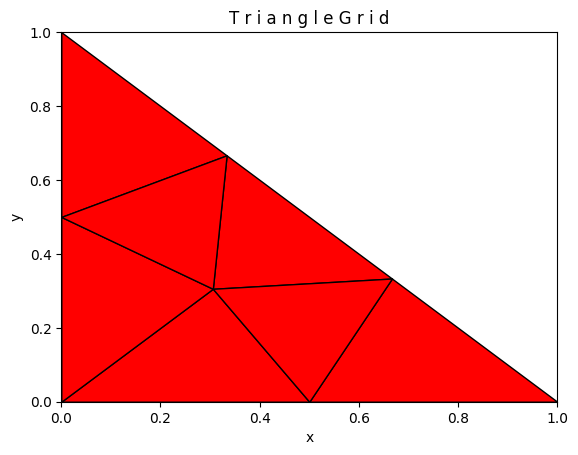

In [34]:
side_1 = np.array([[0, 1], [0, 0]])
side_2 = np.array([[1, 0], [0, 1]])
side_3 = np.array([[0, 0], [1, 0]])
boundary = [side_1, side_2, side_3]
domain = pp.Domain(polytope=boundary)

sd = pg.grid_from_domain(domain, mesh_size, as_mdg=False)
pp.plot_grid(sd, plot_2d=True)

This functionality can be useful also for constructing concave domains

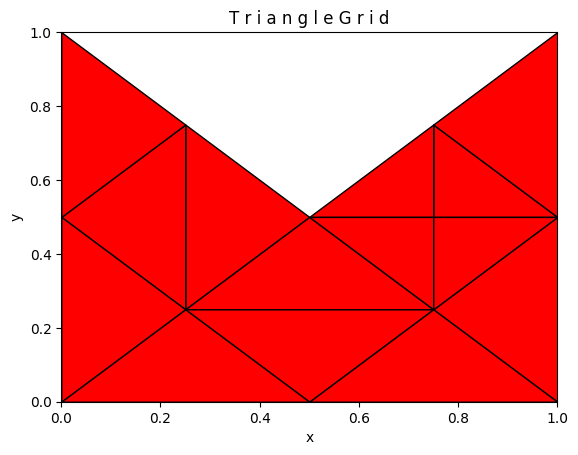

In [35]:
side_1 = np.array([[0, 1], [0, 0]])
side_2 = np.array([[1, 1], [0, 1]])
side_3 = np.array([[1, 0.5], [1, 0.5]])
side_4 = np.array([[0.5, 0], [0.5, 1]])
side_5 = np.array([[0, 0], [1, 0]])
boundary = [side_1, side_2, side_3, side_4, side_5]
domain = pp.Domain(polytope=boundary)

sd = pg.grid_from_domain(domain, mesh_size, as_mdg=False)
pp.plot_grid(sd, plot_2d=True)

If the nodes that define the boundary are known and ordered, it is possible to use them for creating a grid.

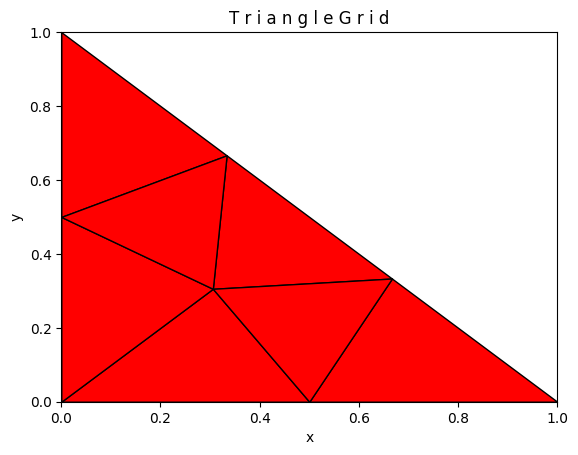

In [36]:
pts = np.array([[0, 1, 0], [0, 0, 1]])
sd = pg.grid_from_boundary_pts(pts, mesh_size, as_mdg=False)
pp.plot_grid(sd, plot_2d=True)

Again, the construction also work in the case of a concave domain.

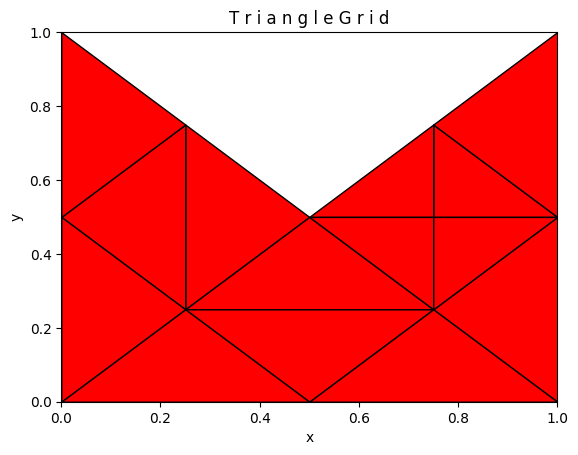

In [37]:
pts = np.array([[0, 1, 1, 0.5, 0], [0, 0, 1, 0.5, 1]])
sd = pg.grid_from_boundary_pts(pts, mesh_size, as_mdg=False)
pp.plot_grid(sd, plot_2d=True)

If for a given set of points we want to construct a grid from its convex hull, we can use some functionalities already present in `scipy`. Here an example

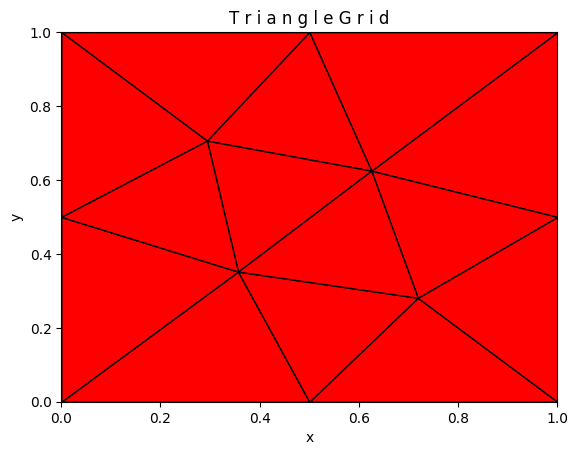

In [38]:
from scipy.spatial import ConvexHull

to_keep = ConvexHull(pts.T).vertices
pts_convex = pts[:, to_keep]

sd = pg.grid_from_boundary_pts(pts_convex, mesh_size, as_mdg=False)
pp.plot_grid(sd, plot_2d=True)